In [10]:
# Mount Google Drive to access the data file
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import Required Libraries

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

Load the datasets

In [12]:
traffic_data_path = r"/content/drive/MyDrive/Predicting City Traffic Flow Based on Weather and Events/cleaned_traffic_weather_dataset.csv"
weather_data_path = r"/content/drive/MyDrive/Predicting City Traffic Flow Based on Weather and Events/weather.csv"

traffic_df = pd.read_csv(traffic_data_path)
weather_df = pd.read_csv(weather_data_path)

Parse datetime columns for aggregation

In [13]:
traffic_df['date'] = pd.to_datetime(traffic_df['updated_at_30min']).dt.date
weather_df['date'] = pd.to_datetime(weather_df['date']).dt.date


Aggregate traffic data to daily level

In [14]:
traffic_daily = traffic_df.groupby('date')['velocity'].agg(['mean', 'median', 'std']).reset_index()
traffic_daily.columns = ['date', 'mean_velocity', 'median_velocity', 'std_velocity']

diplay few rows of traffic_daily

In [15]:
traffic_daily

,date,mean_velocity,median_velocity,std_velocity
0,2020-08-03,19.967187,20.0,11.491157
1,2020-09-11,19.550000,8.0,19.782849
2,2020-11-27,9.000000,9.0,NaN
3,2020-11-30,86.000000,86.0,NaN
4,2020-12-01,47.707692,49.0,5.962705
5,2020-12-06,44.545455,47.0,10.985114
6,2020-12-18,1.000000,1.0,NaN
7,2020-12-24,19.950820,9.0,24.229559
8,2021-01-04,17.157895,15.0,15.221287
9,2021-01-15,25.104348,22.0,20.714168


Merge with weather data

In [16]:
merged_df = pd.merge(weather_df, traffic_daily, on='date', how='inner')

Drop rows with missing values after merge

In [17]:
merged_df = merged_df.dropna()

Display merged df

In [18]:
merged_df

,province,max,min,wind,wind_d,rain,humidi,cloud,pressure,date,mean_velocity,median_velocity,std_velocity
0,Bac Lieu,30,21,13,E,0.4,78,56,1009,2021-01-04,17.157895,15.0,15.221287
1,Bac Lieu,29,22,11,E,0.0,77,25,1010,2021-01-15,25.104348,22.0,20.714168
2,Bac Lieu,29,23,9,ESE,16.0,81,70,1010,2021-01-23,8.272727,1.0,8.776000
3,Bac Lieu,35,27,12,S,0.0,60,8,1005,2021-03-31,22.329670,21.0,19.805193
4,Bac Lieu,33,27,11,SSE,0.9,66,49,1010,2021-04-14,29.486486,31.0,15.413958
...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,Soc Trang,31,26,16,SW,7.2,80,57,1006,2020-08-03,19.967187,20.0,11.491157
553,Soc Trang,32,27,10,SW,0.9,77,40,1008,2020-09-11,19.550000,8.0,19.782849
555,Soc Trang,28,23,23,ENE,4.7,83,73,1010,2020-12-01,47.707692,49.0,5.962705
556,Soc Trang,30,22,7,SW,0.0,78,24,1011,2020-12-06,44.545455,47.0,10.985114


In [27]:
merged_df.columns

Index(['province', 'max', 'min', 'wind', 'wind_d', 'rain', 'humidi', 'cloud',
       'pressure', 'date', 'mean_velocity', 'median_velocity', 'std_velocity'],
      dtype='object')

Prepare features and target

In [19]:
features = merged_df[['rain', 'humidi', 'cloud', 'pressure', 'max', 'min']]
target = merged_df['mean_velocity']  # Target: mean daily velocity

Split the data

In [20]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

Train the Random Forest Model

In [21]:
rf = RandomForestRegressor(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

Evaluate the model

In [22]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

Feature Importances

In [23]:
feature_importances = pd.DataFrame({'Feature': features.columns, 'Importance': rf.feature_importances_})
print("\nFeature Importances:")
print(feature_importances.sort_values(by='Importance', ascending=False))


Feature Importances:
    Feature  Importance
3  pressure    0.426548
5       min    0.142711
1    humidi    0.135790
2     cloud    0.119189
0      rain    0.105399
4       max    0.070363


Display results

In [24]:

print("Training Metrics:")
print(f"MAE: {train_mae}, MSE: {train_mse}, R²: {train_r2}")

print("\nTesting Metrics:")
print(f"MAE: {test_mae}, MSE: {test_mse}, R²: {test_r2}")

Training Metrics:
MAE: 1.7331792032930518, MSE: 8.800670673663507, R²: 0.9469253985836864

Testing Metrics:
MAE: 4.021628443580721, MSE: 42.96823180479537, R²: 0.7716545601344047


Actual vs Predicted Traffic Velocity plot

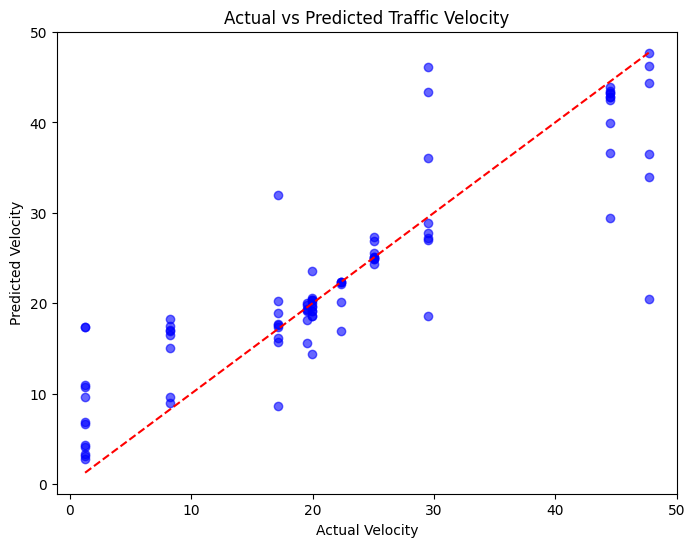

In [25]:

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel("Actual Velocity")
plt.ylabel("Predicted Velocity")
plt.title("Actual vs Predicted Traffic Velocity")
plt.show()


Save the Model

In [26]:
import joblib

# Save the model
joblib.dump(rf, "random_forest_traffic_model.pkl")
print("Model saved successfully!")


Model saved successfully!


Download random_forest_traffic_model

In [29]:
from google.colab import files

# Replace the filename with your model's file path
files.download("random_forest_traffic_model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Save to new CSV file

In [30]:
merged_df.to_csv("Daily_Average_Traffic_Weather", index=False)